In [1]:
import pandas as pd
import numpy as np
import scipy
from scipy.stats import uniform
import itertools
import matplotlib.pyplot as plt
import json
import logging
from tabulate import tabulate
import random

#call free data from nltk
from nltk.corpus import movie_reviews

logger = logging.getLogger(__name__)

#call sklearn text feature engineering packages
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.decomposition import TruncatedSVD
#call sklearn cross_validation package
from sklearn.model_selection import train_test_split
# instead of GridSearch. RandomSearch is used.
from sklearn.model_selection import RandomizedSearchCV
#call sklearn algorithm/classifiers
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC

from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report
#import useful_qn_classifier
#import useful_question_classifier as c

#class for plotting nice confusion matrix
def plot_confusion_matrix(cm, target_names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45)
    plt.yticks(tick_marks, target_names)
    plt.tight_layout()
    
    fmt = '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [6]:
#documents = [(list(movie_reviews.words(fileid)),category)
#            for category in movie_reviews.categories()
#            for fileid in movie_reviews.fileids(category)]
#random.shuffle(documents)

#documents = pd.DataFrame(movie_reviews, columns=['filename', 'tag', 'text'])
reviews = []
for fileid in movie_reviews.fileids():
    tag, filename = fileid.split('/')
    reviews.append((filename, tag, movie_reviews.raw(fileid)))

df = pd.DataFrame(reviews, columns=['filename', 'tag', 'text'])
df.count()
df.head()

,filename,tag,text
0,cv000_29416.txt,neg,"plot : two teen couples go to a church party ,..."
1,cv001_19502.txt,neg,the happy bastard's quick movie review \ndamn ...
2,cv002_17424.txt,neg,it is movies like these that make a jaded movi...
3,cv003_12683.txt,neg,""" quest for camelot "" is warner bros . ' firs..."
4,cv004_12641.txt,neg,synopsis : a mentally unstable man undergoing ...


In [16]:
IsNeg = []
for i in df['tag']:
    if i == 'pos':
        IsNeg.append(0)
    else:
        IsNeg.append(1)     
df['IsNeg'] = IsNeg

Grp2 = df.groupby('IsNeg').size()
print(Grp2)
df.head()

IsNeg
0    1000
1    1000
dtype: int64


,filename,tag,text,IsNeg
0,cv000_29416.txt,neg,"plot : two teen couples go to a church party ,...",1
1,cv001_19502.txt,neg,the happy bastard's quick movie review \ndamn ...,1
2,cv002_17424.txt,neg,it is movies like these that make a jaded movi...,1
3,cv003_12683.txt,neg,""" quest for camelot "" is warner bros . ' firs...",1
4,cv004_12641.txt,neg,synopsis : a mentally unstable man undergoing ...,1


In [21]:
from sklearn.utils import shuffle
df = shuffle(df)

print(df['IsNeg'])

18      1
1781    0
1783    0
741     1
1992    0
204     1
1699    0
1775    0
658     1
1288    0
13      1
1769    0
400     1
235     1
1148    0
431     1
412     1
598     1
1811    0
843     1
533     1
1232    0
821     1
1476    0
1796    0
1315    0
547     1
196     1
897     1
861     1
       ..
1289    0
1082    0
1467    0
1658    0
124     1
1045    0
1531    0
1196    0
548     1
1801    0
985     1
332     1
1921    0
1408    0
1317    0
117     1
1720    0
1879    0
39      1
626     1
1988    0
1209    0
638     1
849     1
1257    0
1178    0
984     1
1459    0
903     1
1019    0
Name: IsNeg, Length: 2000, dtype: int64


In [22]:
#split the variables.
X_train=df['text']
Y_train=df['IsNeg']
#define train_test data.
X_train, X_validation, Y_train, Y_validation = train_test_split(X_train, Y_train, test_size=0.5)
X_train.head()

1604    brian depalma needs a hit * really * badly . \...
259      " mercury rising " has numerous flaws , but t...
1045    `we run tings . \ntings don't run we . ' \n-so...
216     as far as " mystery men " is concerned , the b...
1149    the long and illustrious career of robin willi...
Name: text, dtype: object

In [23]:
# feature engineering method 2: Enhanced Tfidf Vectorizer
tv = TfidfVectorizer(min_df=1,stop_words='english',lowercase=True)
X_traintv = tv.fit_transform(X_train)
X_validationtv = tv.transform(X_validation)

# feature selection by top 10 percentile:
#selector = SelectPercentile(f_classif, percentile = 20)
#selector.fit(X_traintv,Y_train)
#X_traintv = selector.transform(X_traintv)
#X_validationtv = selector.transform(X_validationtv)

In [24]:
X_traintv[0]

<1x29033 sparse matrix of type '<class 'numpy.float64'>'
	with 328 stored elements in Compressed Sparse Row format>

In [25]:
print(X_traintv[0])

  (0, 3407)	0.03048280038471108
  (0, 6864)	0.27430089296019927
  (0, 17331)	0.022597067118917687
  (0, 12133)	0.021414457317236686
  (0, 20783)	0.012835817450675274
  (0, 2153)	0.0302716812437137
  (0, 22536)	0.043218546657126995
  (0, 2749)	0.0144740347089333
  (0, 27393)	0.08643709331425399
  (0, 155)	0.03615450213279436
  (0, 22736)	0.01488088020229368
  (0, 4138)	0.039185841851457036
  (0, 28096)	0.023700104969215343
  (0, 20589)	0.03523836585257714
  (0, 3823)	0.04474949678830924
  (0, 18620)	0.021887805729196207
  (0, 7300)	0.03846298118926094
  (0, 3117)	0.043218546657126995
  (0, 27589)	0.04474949678830924
  (0, 9831)	0.039185841851457036
  (0, 5500)	0.03721210385201709
  (0, 8143)	0.023388195316676637
  (0, 5505)	0.026521937394818774
  (0, 4038)	0.6541252870284887
  (0, 28191)	0.08194257066613177
  :	:
  (0, 10123)	0.03999393132044318
  (0, 25166)	0.03405933033111092
  (0, 9875)	0.027845416792809424
  (0, 2106)	0.043218546657126995
  (0, 19923)	0.039185841851457036
  (0, 4366

In [26]:
X_traintv.shape

(1000, 29033)

In [27]:
lsa = TruncatedSVD(n_components=100, n_iter=20)
lsa.fit(X_traintv)
#Lsa is like PCA

TruncatedSVD(algorithm='randomized', n_components=100, n_iter=20,
       random_state=None, tol=0.0)

In [28]:
lsa.components_[0]
#importance of term to the concept, position is the position of the term

array([0.00105857, 0.01093427, 0.00027484, ..., 0.00394096, 0.00034469,
       0.00055663])

In [29]:
terms = tv.get_feature_names()
for i, comp in enumerate(lsa.components_):
    termsInComp = zip (terms,comp)
    sortedTerms = sorted(termsInComp, key=lambda x: x[1], reverse=True) [:10]
    print ("Concept %d:" % i)
    for term in sortedTerms:
        print (term[0])
    print (" ")

Concept 0:
film
movie
like
just
good
time
story
characters
character
really
 
Concept 1:
truman
film
life
carrey
joe
world
town
father
love
christof
 
Concept 2:
trek
star
wars
film
jedi
effects
planet
alien
insurrection
phantom
 
Concept 3:
scream
horror
truman
film
julie
killer
williamson
summer
slasher
trek
 
Concept 4:
truman
carrey
movie
christof
weir
burbank
jim
batman
seahaven
niccol
 
Concept 5:
batman
scream
jackie
robin
film
arnold
horror
mr
schumacher
freeze
 
Concept 6:
jackie
chan
truman
tarantino
brown
ordell
carrey
pulp
grier
trek
 
Concept 7:
joe
death
pitt
truman
hopkins
black
forlani
scream
jackie
tarzan
 
Concept 8:
trek
batman
star
toy
scream
disney
robin
jackie
comedy
woody
 
Concept 9:
trek
harry
star
insurrection
melvin
simon
smith
ba
ku
carter
 
Concept 10:
toy
harry
woody
godzilla
disney
allen
tarzan
buzz
animation
mulan
 
Concept 11:
wars
jedi
phantom
10
jar
anakin
menace
lucas
obi
movie
 
Concept 12:
10
godzilla
trek
joe
tarzan
west
film
li
disney
york
 
Conc

In [30]:
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer
#from sklearn.pipeline import make_pipeline

# Our scoring metric. F1 for useful instances
scoring = make_scorer(f1_score, pos_label=1, average='binary')
# Create regularization penalty space
penalty = ['l1', 'l2']
# Create regularization hyperparameter distribution using uniform distribution
C = [1, 2, 4, 8, 16, 32]

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
LogR = LogisticRegression()
clf_LogR = RandomizedSearchCV(LogR, hyperparameters, scoring=scoring, random_state=1, n_iter=10, cv=5, verbose=0, n_jobs=-1)

In [31]:
# fit Count Vectorizer's features
clf_LogR.fit(X_traintv,Y_train)

RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=10, n_jobs=-1,
          param_distributions={'C': [1, 2, 4, 8, 16, 32], 'penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=1, refit=True,
          return_train_score='warn',
          scoring=make_scorer(f1_score, pos_label=1, average=binary),
          verbose=0)

             precision    recall  f1-score   support

          0       0.84      0.80      0.82       512
          1       0.80      0.84      0.82       488

avg / total       0.82      0.82      0.82      1000

Best Penalty: l2
Best C: 2


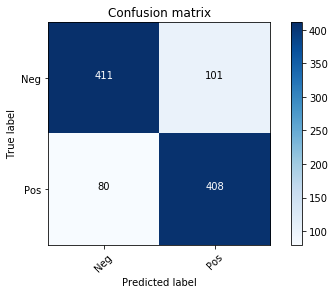

In [33]:
#Run Prediction
y_true, y_pred = Y_validation, clf_LogR.predict(X_validationtv)
#Print Best Model in LogR
print (classification_report(y_true, y_pred))
print('Best Penalty:', clf_LogR.best_estimator_.get_params()['penalty'])
print('Best C:', clf_LogR.best_estimator_.get_params()['C'])
#Print Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, ['Neg', 'Pos'])
# This explains the really really low recall rate.

In [34]:
cv_results = clf_LogR.cv_results_
rows = []
for i, params in enumerate(cv_results['params']):
    rows.append((
        json.dumps(params, sort_keys=True),
        '{:.3f} +/- {:.3f}'.format(cv_results['mean_train_score'][i], cv_results['std_train_score'][i]),
        '{:.3f} +/- {:.3f}'.format(cv_results['mean_test_score'][i], cv_results['std_test_score'][i]),
        '{:.3f}'.format(cv_results['mean_fit_time'][i])
        ))
print('Random search results:\n{}'.format(tabulate(rows, headers=['Parameter', 'Train', 'Validation', 'Fit time'], tablefmt='psql')))
print('Best parameter is {} with score of {}.'.format(json.dumps(clf_LogR.best_params_, sort_keys=True), clf_LogR.best_score_))

Random search results:
+----------------------------+-----------------+-----------------+------------+
| Parameter                  | Train           | Validation      |   Fit time |
|----------------------------+-----------------+-----------------+------------|
| {"C": 2, "penalty": "l1"}  | 0.797 +/- 0.005 | 0.701 +/- 0.049 |      0.088 |
| {"C": 2, "penalty": "l2"}  | 0.999 +/- 0.000 | 0.820 +/- 0.029 |      0.076 |
| {"C": 4, "penalty": "l1"}  | 0.940 +/- 0.006 | 0.761 +/- 0.031 |      0.147 |
| {"C": 32, "penalty": "l1"} | 1.000 +/- 0.000 | 0.781 +/- 0.023 |      0.174 |
| {"C": 1, "penalty": "l2"}  | 0.994 +/- 0.001 | 0.809 +/- 0.029 |      0.052 |
| {"C": 8, "penalty": "l1"}  | 0.996 +/- 0.002 | 0.776 +/- 0.027 |      0.159 |
| {"C": 1, "penalty": "l1"}  | 0.665 +/- 0.014 | 0.648 +/- 0.036 |      0.138 |
| {"C": 8, "penalty": "l2"}  | 1.000 +/- 0.000 | 0.815 +/- 0.030 |      0.08  |
| {"C": 32, "penalty": "l2"} | 1.000 +/- 0.000 | 0.814 +/- 0.024 |      0.102 |
| {"C": 16, "pena

C:\Users\Hui Kiang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\Hui Kiang\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:122: FutureWarning: You are accessing a training score ('std_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
